## 1. 데이터 수집

In [2]:
import requests  # HTTP 요청을 보내고 응답을 받을 수 있도록 해주는 라이브러리
import xml.etree.ElementTree as ET  # XML 데이터를 파싱(분석)하고 다루기 위한 라이브러리
import pandas as pd  # 데이터프레임을 활용하여 데이터를 효율적으로 처리하기 위한 라이브러리
from datetime import datetime, timedelta  # 날짜 및 시간 계산을 위해 필요한 라이브러리
import numpy as np

In [ ]:
api_key = 'YOUTR_API_KEY_HERE'  # 서울시 공공데이터 포털에서 발급받은 API 키
estate_url = 'http://openapi.seoul.go.kr:8088/'

In [4]:
# 데이터 로드
# API URL 구성 (날짜별 버스 데이터 요청)
url = f'http://openapi.seoul.go.kr:8088/{api_key}/xml/tbLnOpendataRtmsV/1/1000/'

# API 요청을 보냄
response = requests.get(url)  # requests 라이브러리를 사용하여 GET 요청 보내기)
print("답: 상태 코드:", response.status_code)

# XML 응답 데이터를 파싱
root = ET.fromstring(response.content)  # API 응답 데이터를 XML 형식으로 변환)

root

답: 상태 코드: 200


<Element 'tbLnOpendataRtmsV' at 0x000001D6AD916E80>

In [5]:
# 데이터를 저장할 리스트 생성
estate_data = []

# 목표 : "물건이 비싼 지역과 원인을 분석"
# THING_AMT	- 물건금액(만원)
# CGG_NM	- 자치구명, STDG_CD   - 법정동명
# BLDG_NM - 건물명, ARCH_AREA - 건물 면적, LAND_AREA - 토지 면적, FLR - 층, ARCH_YR - 건축년도

for row in root.findall('.//row'):
    estate_data.append({
        '자치구명': row.find('CGG_NM').text if row.find('CGG_NM') is not None else np.nan,
        # '법정동명': row.find('STDG_CD').text if row.find('STDG_CD') is not None else np.nan, # -> 동까지 필요 없을듯?
        '건물명': row.find('BLDG_NM').text if row.find('BLDG_NM') is not None else np.nan,
        '건물면적': row.find('ARCH_AREA').text if row.find('ARCH_AREA') is not None else np.nan,
        '토지면적': row.find('LAND_AREA').text if row.find('LAND_AREA') is not None else np.nan,
        '층': row.find('FLR').text if row.find('FLR') is not None else np.nan,
        '건축년도': row.find('ARCH_YR').text if row.find('ARCH_YR') is not None else np.nan,
        '물건금액(만원)': row.find('THING_AMT').text if row.find('THING_AMT') is not None else np.nan
    })

estate_data = pd.DataFrame(estate_data)
estate_data

,자치구명,건물명,건물면적,토지면적,층,건축년도,물건금액(만원)
0,성북구,(266-157),31.68,18.000000,1,2006,9000
1,광진구,나경타운,49.59,30.000000,2,2015,39300
2,성동구,(229-13),29.88,41.480000,8,1991,8000
3,구로구,구로현대,56.49,0.000000,2,1992,57700
4,서초구,CM빌,29.13,20.000000,3,2017,34200
...,...,...,...,...,...,...,...
995,구로구,구로현대,84.57,0.000000,4,1992,73200
996,성북구,래미안길음센터피스,59.97,0.000000,7,2019,118500
997,노원구,캐슬빌,54.25,33.000000,2,2013,23000
998,양천구,다온숲,32,20.000000,4,2016,44500


In [6]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   자치구명      1000 non-null   object
 1   건물명       983 non-null    object
 2   건물면적      1000 non-null   object
 3   토지면적      1000 non-null   object
 4   층         983 non-null    object
 5   건축년도      1000 non-null   object
 6   물건금액(만원)  1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


## 2. 데이터 전처리

In [7]:
# 수치형인데 범주형 타입으로 되어있는 피처 타입 변환
num_col = ['건물면적', '토지면적', '층', '건축년도', '물건금액(만원)']

for col in num_col:
    estate_data[col] = pd.to_numeric(estate_data[col], errors='coerce') # coerce : 변환할 수 없는 건 NA 처리

print(estate_data.info())
print(estate_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   자치구명      1000 non-null   object 
 1   건물명       983 non-null    object 
 2   건물면적      1000 non-null   float64
 3   토지면적      1000 non-null   float64
 4   층         983 non-null    float64
 5   건축년도      999 non-null    float64
 6   물건금액(만원)  1000 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 54.8+ KB
None
자치구명         0
건물명         17
건물면적         0
토지면적         0
층           17
건축년도         1
물건금액(만원)     0
dtype: int64


In [8]:
# 결측치가 매우 적으므로 과감하게 삭제
estate_data = estate_data.dropna()

In [9]:
estate_data

,자치구명,건물명,건물면적,토지면적,층,건축년도,물건금액(만원)
0,성북구,(266-157),31.68,18.00,1.0,2006.0,9000
1,광진구,나경타운,49.59,30.00,2.0,2015.0,39300
2,성동구,(229-13),29.88,41.48,8.0,1991.0,8000
3,구로구,구로현대,56.49,0.00,2.0,1992.0,57700
4,서초구,CM빌,29.13,20.00,3.0,2017.0,34200
...,...,...,...,...,...,...,...
995,구로구,구로현대,84.57,0.00,4.0,1992.0,73200
996,성북구,래미안길음센터피스,59.97,0.00,7.0,2019.0,118500
997,노원구,캐슬빌,54.25,33.00,2.0,2013.0,23000
998,양천구,다온숲,32.00,20.00,4.0,2016.0,44500


In [10]:
print(estate_data['토지면적'].value_counts()) # 토지면적이 0인게 절반 이상 -> 중앙값 대체 or 피처 제거 고려 (우선 제거하겠음)
print(estate_data.drop('토지면적', axis=1, inplace=True))

토지면적
0.0000     567
19.0000     23
24.0000     19
23.0000     18
21.0000     17
          ... 
33.2100      1
59.5400      1
25.3210      1
5.0000       1
28.5093      1
Name: count, Length: 142, dtype: int64
None


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_16452\2169121293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(estate_data.drop('토지면적', axis=1, inplace=True))


In [11]:
# IQR 기반 이상치 탐색 및 제거
def remove_outliers_iqr(df, cols):
    cleaned_df = df.copy()
    for col in cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        before = len(cleaned_df)
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
        after = len(cleaned_df)

        print(f"[{col}] IQR 범위: {lower:.2f} ~ {upper:.2f}, 제거된 행: {before - after}")

    return cleaned_df

# 적용할 수치형 컬럼
cols_to_check = ['물건금액(만원)', '건물면적', '건축년도']

# 이상치 제거
estate_data_clean = remove_outliers_iqr(estate_data, cols_to_check)

print("\n이상치 제거 후 데이터셋 크기:", estate_data_clean.shape)

[물건금액(만원)] IQR 범위: -83500.00 ~ 219500.00, 제거된 행: 27
[건물면적] IQR 범위: -33.19 ~ 154.72, 제거된 행: 2
[건축년도] IQR 범위: 1968.50 ~ 2044.50, 제거된 행: 10

이상치 제거 후 데이터셋 크기: (943, 6)


In [12]:
estate_data_clean= estate_data_clean.drop(columns=['건물명'])
estate_data_clean['건축년도'] = estate_data_clean['건축년도'].astype(int)
estate_data_clean['층'] = estate_data_clean['층'].astype(int)

estate_data_clean['자치구명'] = estate_data_clean['자치구명'].astype('category')
estate_data_clean['자치구명_code'] = estate_data_clean['자치구명'].cat.codes
estate_data_clean

,자치구명,건물면적,층,건축년도,물건금액(만원),자치구명_code
0,성북구,31.68,1,2006,9000,16
1,광진구,49.59,2,2015,39300,5
2,성동구,29.88,8,1991,8000,15
3,구로구,56.49,2,1992,57700,6
4,서초구,29.13,3,2017,34200,14
...,...,...,...,...,...,...
995,구로구,84.57,4,1992,73200,6
996,성북구,59.97,7,2019,118500,16
997,노원구,54.25,2,2013,23000,8
998,양천구,32.00,4,2016,44500,18


-----------

## 3. 기본 데이터 모델 성능

📌 RandomForest 회귀 성능
MAE : 19476.67451499118
RMSE: 28320.324692792427
R²  : 0.6172813026303903


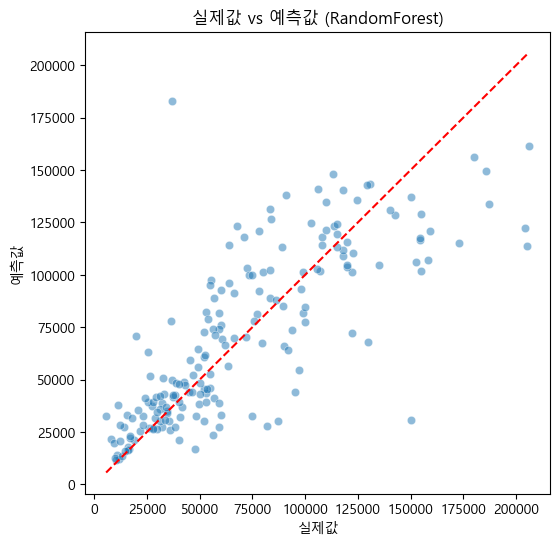

C:\Users\SSAFY\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


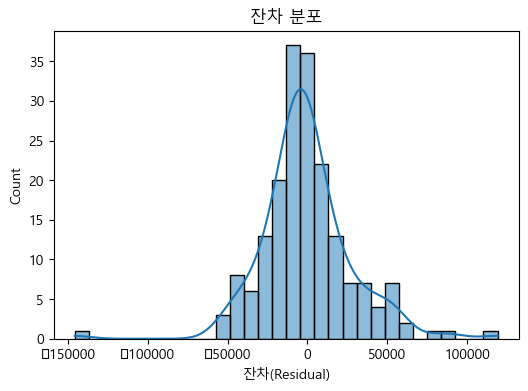

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. 데이터 준비
# -----------------------------
# X(피처), y(타겟) 정의
X = estate_data_clean[['자치구명_code', '건물면적', '층', '건축년도']]
y = estate_data_clean['물건금액(만원)']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 2. 랜덤포레스트 회귀 모델
# -----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📌 RandomForest 회귀 성능")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

# -----------------------------
# 3. 시각화
# -----------------------------
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')  

# (1) 실제값 vs 예측값
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("실제값 vs 예측값 (RandomForest)")
plt.show()

# (2) 잔차 분포
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("잔차(Residual)")
plt.title("잔차 분포")
plt.show()

- MAE ≈ 19,476 (만원 단위 → 약 1.9억 차이)

- RMSE ≈ 28,320 (약 2.8억 차이)

- R² ≈ 0.617 → 약 62% 설명력

📌 XGBoost 회귀 성능
MAE : 17425.240234375
RMSE: 25003.91009422326
R²  : 0.7016685009002686


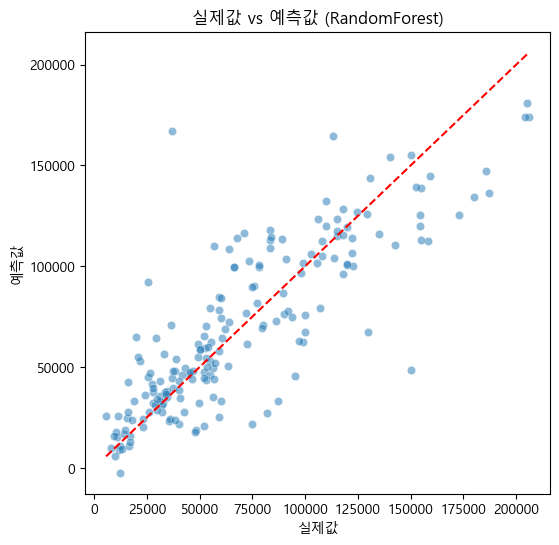

C:\Users\SSAFY\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


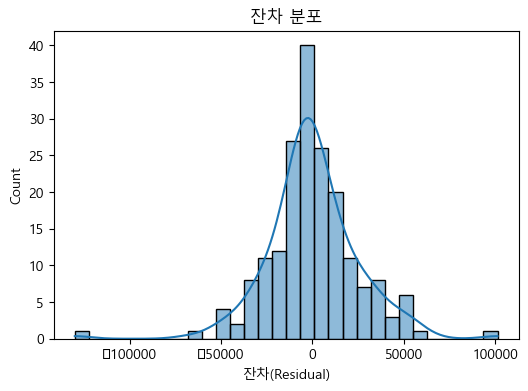

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# -----------------------------
# 데이터 준비 (앞에서 만든 X, y 그대로 사용)
# -----------------------------
X = estate_data_clean[['자치구명_code', '건물면적', '층', '건축년도']]
y = estate_data_clean['물건금액(만원)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# XGBoost Regressor
# -----------------------------
xgb_model = xgb.XGBRegressor(
    n_estimators=500,      # 트리 개수
    learning_rate=0.05,    # 학습률
    max_depth=6,           # 트리 깊이
    subsample=0.8,         # 샘플 비율
    colsample_bytree=0.8,  # 피처 샘플 비율
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📌 XGBoost 회귀 성능")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

# -----------------------------
# 3. 시각화
# -----------------------------
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')  
# (1) 실제값 vs 예측값
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("실제값 vs 예측값 (RandomForest)")
plt.show()

# (2) 잔차 분포
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("잔차(Residual)")
plt.title("잔차 분포")
plt.show()


- MAE: 예측 오차가 약 2,000만원 감소

- RMSE: 예측 편차가 줄어듦 (약 3,300만원 감소)

- R²: 설명력이 62% → 70% 로 개선

------------------

## 4. 피처엔지니어링

In [15]:
estate_fe = estate_data_clean.copy() 
estate_fe['연식'] = 2025 - estate_fe['건축년도']
# 층을 분위수 기준으로 5등분
estate_fe['층_구간'] = pd.qcut(
    estate_fe['층'],
    q=3,            # 5개 구간
    labels=False,   # 0~4 숫자 코드
    duplicates='drop'  # 중복 경계값 있을 경우 제거
)
estate_fe['연식_구간'] = pd.qcut(
    estate_fe['연식'],
    q=3,            # 5개 구간
    labels=False,   # 0~4 숫자 코드
    duplicates='drop'  # 중복 경계값 있을 경우 제거
)
estate_fe['건물면적*연식'] = estate_fe['건물면적'] * estate_fe['연식']
estate_fe

,자치구명,건물면적,층,건축년도,물건금액(만원),자치구명_code,연식,층_구간,연식_구간,건물면적*연식
0,성북구,31.68,1,2006,9000,16,19,0,1,601.92
1,광진구,49.59,2,2015,39300,5,10,0,0,495.90
2,성동구,29.88,8,1991,8000,15,34,1,2,1015.92
3,구로구,56.49,2,1992,57700,6,33,0,2,1864.17
4,서초구,29.13,3,2017,34200,14,8,0,0,233.04
...,...,...,...,...,...,...,...,...,...,...
995,구로구,84.57,4,1992,73200,6,33,0,2,2790.81
996,성북구,59.97,7,2019,118500,16,6,1,0,359.82
997,노원구,54.25,2,2013,23000,8,12,0,0,651.00
998,양천구,32.00,4,2016,44500,18,9,0,0,288.00


In [16]:
# -----------------------------
# 1. 데이터 준비
# -----------------------------
# X(피처), y(타겟) 정의
X = estate_fe[['자치구명_code', '건물면적', '층', '건축년도','연식','건물면적*연식','층_구간','연식_구간']]
y = estate_fe['물건금액(만원)']

📌 RandomForest 회귀 성능
MAE : 19004.85691358025
RMSE: 27049.70594954791
R²  : 0.6508529957555144


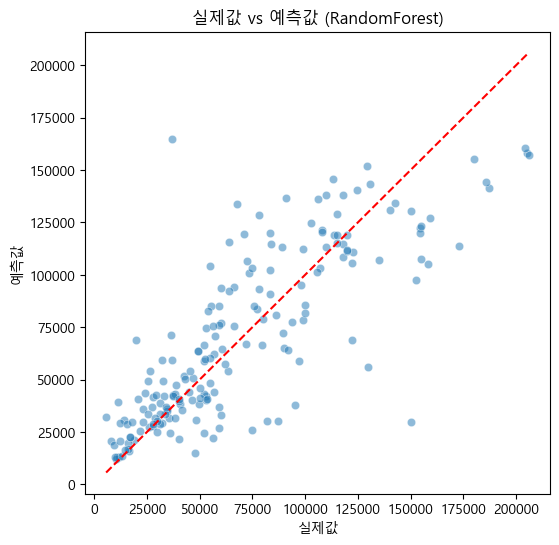

C:\Users\SSAFY\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


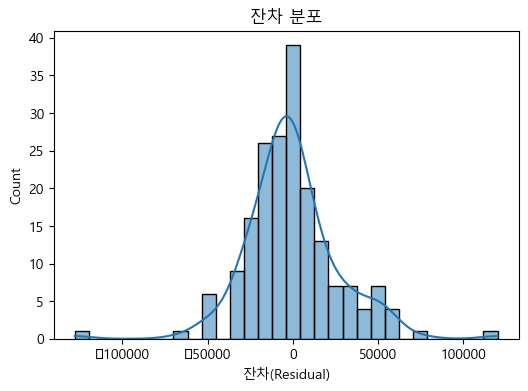

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 2. 랜덤포레스트 회귀 모델
# -----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📌 RandomForest 회귀 성능")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

# -----------------------------
# 3. 시각화
# -----------------------------
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')  

# (1) 실제값 vs 예측값
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("실제값 vs 예측값 (RandomForest)")
plt.show()

# (2) 잔차 분포
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("잔차(Residual)")
plt.title("잔차 분포")
plt.show()

📌 XGBoost 회귀 성능
MAE : 16669.064453125
RMSE: 23783.39454325223
R²  : 0.7300825715065002


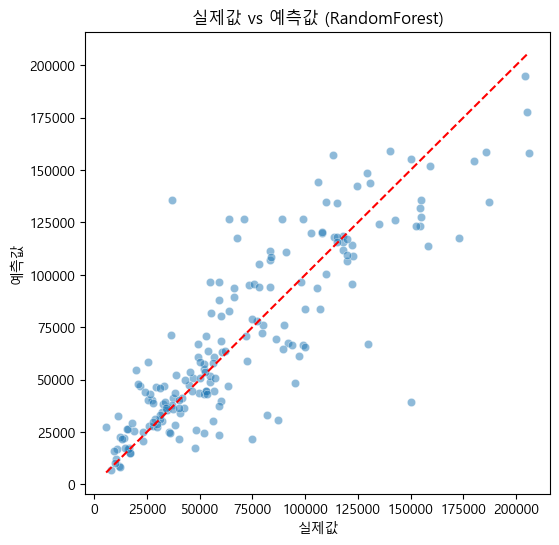

C:\Users\SSAFY\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


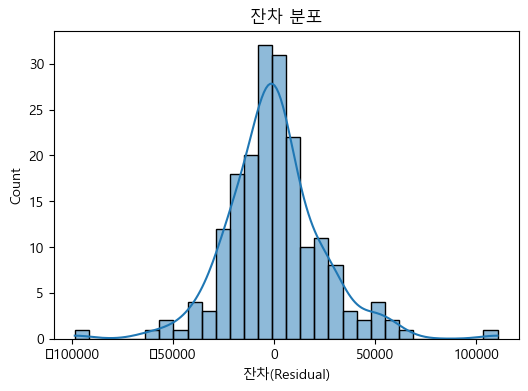

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# XGBoost Regressor
# -----------------------------
xgb_model = xgb.XGBRegressor(
    n_estimators=500,      # 트리 개수
    learning_rate=0.05,    # 학습률
    max_depth=6,           # 트리 깊이
    subsample=0.8,         # 샘플 비율
    colsample_bytree=0.8,  # 피처 샘플 비율
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📌 XGBoost 회귀 성능")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

# -----------------------------
# 3. 시각화
# -----------------------------
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')  
# (1) 실제값 vs 예측값
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("실제값 vs 예측값 (RandomForest)")
plt.show()

# (2) 잔차 분포
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("잔차(Residual)")
plt.title("잔차 분포")
plt.show()


-----------------

## 5. 하이퍼파라미터 튜닝

In [20]:
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# -----------------------------
# 0) 데이터 준비
# -----------------------------
# 예시: estate_data_clean가 있고, X에 문자열 컬럼이 포함됨
X = estate_fe[['자치구명_code', '건물면적', '층', '건축년도','연식','건물면적*연식','층_구간','연식_구간']]
y = estate_fe['물건금액(만원)']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 1) 전처리기 (문자 → 원핫)
# -----------------------------
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ],
    remainder='passthrough'
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def eval_and_print(name, fitted_pipe, X_te, y_te):
    pred = fitted_pipe.predict(X_te)
    mae  = mean_absolute_error(y_te, pred)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    r2   = r2_score(y_te, pred)
    print(f"\n📌 {name} (GridSearch Best) Test Metrics")
    print("MAE :", f"{mae:,.2f}")
    print("RMSE:", f"{rmse:,.2f}")
    print("R²  :", f"{r2:,.4f}")

# -----------------------------
# 2) XGBoost + GridSearchCV
# -----------------------------
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

xgb_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', xgb_base)
])

# 그리드 크기를 너무 키우면 시간이 오래 걸리니, 작은-중간 규모 예시
param_grid_xgb = {
    'model__n_estimators': [300, 600, 1000],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__min_child_weight': [1, 3, 5],
    'model__reg_lambda': [0.5, 1.0, 2.0],
    'model__reg_alpha': [0.0, 1e-3, 1e-2],
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid_xgb,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print("\n[XGBoost] Best CV RMSE:", -xgb_grid.best_score_)
print("[XGBoost] Best Params:")
for k, v in xgb_grid.best_params_.items():
    print(f"  {k}: {v}")

eval_and_print("XGBoost", xgb_grid.best_estimator_, X_test, y_test)


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits

[XGBoost] Best CV RMSE: 26048.977734375
[XGBoost] Best Params:
  model__colsample_bytree: 0.8
  model__learning_rate: 0.03
  model__max_depth: 6
  model__min_child_weight: 1
  model__n_estimators: 300
  model__reg_alpha: 0.0
  model__reg_lambda: 0.5
  model__subsample: 0.8

📌 XGBoost (GridSearch Best) Test Metrics
MAE : 16,965.65
RMSE: 24,355.47
R²  : 0.7169


---

## 6. 모델, 데이터 처리, 성능 분석 및 느낀점

### 6.1. 데이터 처리 및 전처리
- **API를 통한 데이터 수집**: 서울시 부동산 실거래 데이터를 OpenAPI로부터 수집하여, XML 파싱 및 DataFrame 변환 과정을 거쳤다.
- **결측치 처리**: 수치형 컬럼의 결측치는 개수가 적어 단순 삭제로 처리. 이는 데이터 손실이 적을 때 효과적이나, 결측치가 많을 경우 대체 전략(평균, 중앙값 등)이 필요하다.
- **이상치 제거**: IQR 기반으로 주요 수치형 변수(물건금액, 건물면적, 건축년도)의 이상치를 제거. 이상치 제거는 모델의 일반화 성능을 높이고, 극단값에 의한 왜곡을 방지한다.
- **피처 엔지니어링**: 연식, 층 구간화, 건물면적*연식 등 도메인 지식을 활용한 파생변수 생성. 이는 모델이 더 복잡한 패턴을 학습할 수 있게 도와준다.

### 6.2. 모델링 및 성능 비교
- **RandomForestRegressor**
    - 기본 피처만 사용 시 R² 약 0.62, MAE 약 1.9억, RMSE 약 2.8억 수준.
    - 피처 엔지니어링 후에도 성능이 소폭 개선되었으나, 한계가 존재.
- **XGBoostRegressor**
    - 동일 피처에서 R² 약 0.70, MAE와 RMSE 모두 감소.
    - Gradient Boosting 기반의 앙상블 모델이므로, 비선형성과 변수 간 상호작용을 더 잘 포착.
- **하이퍼파라미터 튜닝**
    - GridSearchCV로 최적 파라미터 탐색 시, 성능이 추가로 개선됨.
    - 하지만 데이터 자체의 한계(피처 다양성 부족, 외부 변수 미포함 등)로 인해 성능 향상 폭은 제한적.

### 6.3. 성능이 향상된 이유/증가하지 않은 이유
- **향상된 이유**
    - 이상치/결측치 제거로 데이터 품질이 개선되어 모델이 더 신뢰성 있게 학습함.
    - 피처 엔지니어링을 통해 단순 변수 외에 연식, 구간화 등 추가 정보를 제공하여 모델의 설명력이 증가.
    - XGBoost와 같은 앙상블 모델은 복잡한 데이터 구조를 더 잘 학습함.
- **증가하지 않은 이유**
    - 외부 변수(예: 입지, 교통, 학군, 경제지표 등) 미포함으로 설명력 한계.
    - 피처 수가 적고, 대부분 수치형 변수에 치우쳐 있어 모델이 학습할 수 있는 정보량이 제한적.
    - 데이터 자체의 노이즈, API 제공 데이터의 한계(업데이트 주기, 표본 수 등)도 영향.

### 6.4. 느낀점 및 개선 방향
- **느낀점**
    - 데이터 전처리와 피처 엔지니어링의 중요성을 체감. 단순히 모델을 바꾸는 것보다 데이터 품질과 변수 설계가 더 큰 영향을 미침.
    - XGBoost 등 앙상블 모델의 강력함을 확인했으나, 데이터가 충분히 다양하지 않으면 한계가 명확함.
    - 실제 부동산 가격 예측에는 다양한 외부 요인(입지, 정책, 인구 등)이 필수적임을 느낌.
- **개선 방향**
    - 외부 데이터(교통, 학군, 상권 등) 추가 및 피처 확장.
    - 시계열적 특성(연도별 트렌드, 계절성 등) 반영.
    - 모델 해석력(Feature Importance, SHAP 등) 분석을 통한 인사이트 도출.
    - 다양한 모델(딥러닝, 앙상블 stacking 등) 실험 및 비교.


###  6.5. 프로젝트 목적 및 의사결정 지원 관점

본 프로젝트의 궁극적인 목적은 **부동산 경매 물건의 실제 시세에 비해 저렴한지(또는 고평가되었는지)를 예측**하여, 투자자나 실수요자가 합리적인 의사결정을 내릴 수 있도록 지원하는 데 있습니다.

- **왜 분석과 예측 모델이 필요한가?**
    - 부동산 경매 시장은 정보의 비대칭성이 크고, 시세 판단이 쉽지 않음.
    - 단순히 물건금액만 보는 것이 아니라, 다양한 속성(위치, 연식, 면적 등)과 과거 거래 데이터를 바탕으로 "적정 시세"를 예측할 수 있다면, 실제 낙찰가가 저평가/고평가인지 판단 가능.
    - 이를 통해 투자자는 리스크를 줄이고, 더 합리적인 입찰 전략을 세울 수 있음.

- **프로젝트의 의의**
    - 데이터 기반의 정량적 분석을 통해, 감(直感)이나 경험에만 의존하던 기존 의사결정 방식을 보완.
    - 예측 모델을 활용해, 특정 물건이 시세 대비 얼마나 매력적인지(저평가/고평가)를 수치로 제시.
    - 궁극적으로는 부동산 시장의 투명성 제고와, 데이터 기반 의사결정 문화 확산에 기여.

- **향후 활용 방안**
    - 예측 결과를 바탕으로 "입찰가 추천 시스템" 개발.
    - 다양한 외부 데이터(실거래가, 인구, 교통 등)와 결합하여, 더 정교한 시세 예측 및 리스크 분석 가능.
    - 실수요자, 투자자, 중개업자 등 다양한 이해관계자에게 맞춤형 정보 제공.
